<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Things" data-toc-modified-id="Import-Things-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Things</a></span></li><li><span><a href="#Anonymous-Funcitons" data-toc-modified-id="Anonymous-Funcitons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anonymous Funcitons</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></div>

# Import Things

In [256]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import matplotlib.gridspec

sns.set()

with open("tidy_output/geometry_data.pkl","rb") as file_in:
    raw_data = pkl.load(file_in)
    
raw_df = pd.DataFrame(raw_data)


raw_df.head()

,A,B,angles,bonds,fill
0,NaN,0,[105.36368698502989],"[0.973000878290579, 0.9730088347812262]",1000
1,NaN,1,[105.35087075683664],"[0.972962025117793, 0.9729614079942821]",1000
2,NaN,10,[105.34794212312683],"[0.9730240372869534, 0.9729868500532556]",1000
3,NaN,11,[105.51502522374619],"[0.9724294901907392, 0.9727270373876404]",1000
4,NaN,12,[105.31514572601299],"[0.9729075432648405, 0.9731076619050572]",1000


# Anonymous Funcitons

In [226]:
filter_by_fill = lambda fill,df=raw_df: df[df.fill==str(fill)]
flatten = lambda l: [j for i in l for j in i]
get_stats = lambda bd,an: [np.mean(bd),np.std(bd)/np.sqrt(len(bd)),np.mean(an),np.std(an)/np.sqrt(len(an))]

# Named Functions


In [301]:

fills = raw_df.fill.unique().tolist()
results_df = pd.DataFrame(columns="bond_avg bond_err angle_avg angle_err".split())
for fill in fills:
    df = filter_by_fill(fill)
    bonds = flatten(df.bonds.values)
    angles = flatten(df.angles.values)
    results_df.loc[fill] = get_stats(bonds,angles)

results_df['fill'] = [25,50,50,75,100]

results_df.head()

,bond_avg,bond_err,angle_avg,angle_err,fill
1000,0.972980,0.000029,105.352569,0.008552,25
1010,0.973016,0.000011,105.341893,0.007274,50
1100,0.972947,0.000041,105.168523,0.013050,50
1110,0.973134,0.000039,105.085020,0.012528,75
1111,0.973222,0.000064,104.805719,0.025258,100


Take the average of the two 50% fills.

In [302]:
merged_results_df = results_df.append(results_df[results_df.fill == 50].mean(axis=0),ignore_index=True)
merged_results_df.drop([1,2],axis=0,inplace=True)
merged_results_df.fill.apply(int)
merged_results_df.sort_values("fill",inplace=True)

In [303]:
merged_results_df.head()

,bond_avg,bond_err,angle_avg,angle_err,fill
0,0.972980,0.000029,105.352569,0.008552,25.0
5,0.972981,0.000026,105.255208,0.010162,50.0
3,0.973134,0.000039,105.085020,0.012528,75.0
4,0.973222,0.000064,104.805719,0.025258,100.0


In [304]:
lit_values = {"bond":[0.973,0.973],"angle":[105.07,104.59],"fill":[50,100]}
lit_df = pd.DataFrame(lit_values)
lit_df.head()

,bond,angle,fill
0,0.973,105.07,50
1,0.973,104.59,100


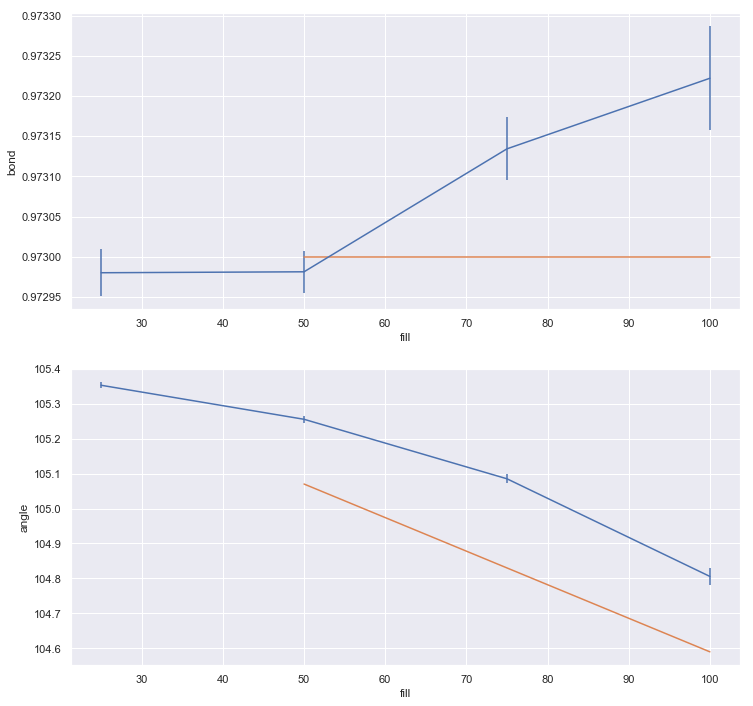

In [310]:
gs = matplotlib.gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(gs[0,0])
plt.errorbar(merged_results_df.fill.values,merged_results_df.bond_avg.values,yerr=merged_results_df.bond_err.values)
sns.lineplot(x="fill",y="bond",data=lit_df,ax=ax1)
ax2 = plt.subplot(gs[1,0])
#sns.lineplot(data=merged_results_df,x="fill",y="angle_avg",ax=ax2)
plt.errorbar(merged_results_df.fill.values,merged_results_df.angle_avg.values,yerr=merged_results_df.angle_err.values)
sns.lineplot(x="fill",y="angle",data=lit_df,ax=ax2)

In [278]:
merged_results_df.fill.values

array([ 25.,  75., 100.,  50.])